<a href="https://colab.research.google.com/github/chinmayee95/pixelhop-/blob/master/imp_pixelhop_stage4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA** **LOADING**

In [1]:
%cd "/content/"
!git clone https://github.com/USC-MCL/EE569_2020Spring.git
!pwd
!ls EE569_2020Spring/
%cd /content/EE569_2020Spring/

/content
Cloning into 'EE569_2020Spring'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 142 (delta 84), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (142/142), 39.11 KiB | 4.35 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/content
cross_entropy.py  lag.py   pixelhop2.py  requirements.txt
cwSaab.py	  llsr.py  README.md	 saab.py
/content/EE569_2020Spring


**LIBRARIES LOADINNG**

In [0]:
import numpy as np
import time
from cross_entropy import Cross_Entropy
from lag import LAG
from llsr import LLSR as myLLSR
from pixelhop2 import Pixelhop2
import skimage
from skimage.util import view_as_windows
import skimage.measure
import numpy as np

In [0]:
def Concat(X, concatArg):
    return X

In [0]:
from skimage.util import view_as_windows
def Shrink(X, shrinkArg):

  win = shrinkArg['win']
  win=3
  hop = shrinkArg['hop']
  # print('Hop:',hop)
  stride = 1
  ch = X.shape[-1]
  # print('Input shape:',X.shape)
  if hop==1:
    X = view_as_windows(X, (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
    X = skimage.measure.block_reduce(X, (1,2,2,1), np.max)
  if hop==2:
    X = view_as_windows(X, (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
    X = skimage.measure.block_reduce(X, (1,2,2,1), np.max)
  if hop==3:
    X = view_as_windows(X, (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
    X = skimage.measure.block_reduce(X, (1,2,2,1), np.max)
  if hop==4:
    X = view_as_windows(X, (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
  # print(X.shape)
  return X

In [0]:
"""neighborhood construction shrink saab concat args"""
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'useDC':True, 'batch':None, 'cw': True},
                {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw': True}]
shrinkArgs = [{'func':Shrink, 'win':5, 'hop':1},
              {'func': Shrink, 'win':5,'hop':2},
              {'func': Shrink, 'win':5,'hop':3},
              {'func': Shrink, 'win':5, 'hop':4}]
concatArg = {'func':Concat}

In [6]:
from keras.datasets import cifar10
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#preprocessing of data - reshape to 0-1
# x_train_50k = x_train.astype('float32')/255
# x_test = x_test.astype('float32')/255

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [0]:
from skimage import io, color
x_train = color.rgb2lab(x_train)
x_test = color.rgb2lab(x_test)

x_train_50k = np.zeros(x_train.shape)
x_train_50k[:,:,:,0] = x_train[:,:,:,0].astype('float32')/100
x_train_50k[:,:,:,1] = x_train[:,:,:,1].astype('float32')/(-110)
x_train_50k[:,:,:,2] = x_train[:,:,:,2].astype('float32')/110
x_test_10k = np.zeros(x_test.shape)
x_test_10k[:,:,:,0] = x_test[:,:,:,0].astype('float32')/100
x_test_10k[:,:,:,1] = x_test[:,:,:,1].astype('float32')/(-110)
x_test_10k[:,:,:,2] = x_test[:,:,:,2].astype('float32')/110

x_test = x_test_10k
x_train = x_train_50k

Selecting 10k images with 1k of each class

In [0]:
size = np.asarray(x_train.shape)
size[0] = 10000
data_10k = np.zeros(size)
ind = np.where(y_train==1)
k=1
for label in range(10):
  ind = np.where(y_train==label)
  ind = ind[0][0:1000]#10k images
  for i in ind:
    if k>=10000:
      break
    data_10k[k,:,:,:] = x_train_50k[i,:,:,:]
    k+=1

# size = np.asarray(x_train.shape)
# size[0] = 1560
# data_10k = np.zeros(size)
# ind = np.where(y_train==1)
# k=1
# for label in range(10):
#   ind = np.where(y_train==label)
#   ind = ind[0][0:156]#10k images
#   for i in ind:
#     if k>=1560:
#       break
#     data_10k[k,:,:,:] = x_train_50k[i,:,:,:]
#     k+=1


In [9]:
data_10k.shape

(10000, 32, 32, 3)

In [0]:
#time start
start_time = time.time()

In [11]:
#train 
phops = Pixelhop2(depth=4, TH1=0.0001, TH2=0.00001, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
phops.fit(data_10k)
train_output = phops.transform(data_10k)
test_transform = phops.transform(x_test)

pixelhop2 fit


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_incremental_pca.py:297: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_incremental_pca.py:297: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_incremental_pca.py:297: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_incremental_pca.py:297: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_incremental_pca.py:297: RuntimeWarning: invalid value encountered in true_divi

pixelhop2 transform
pixelhop2 transform


In [12]:
  print('Output size of hop units:')
  print('Train data:')
  print(train_output[0].shape)
  print(train_output[1].shape)
  print(train_output[2].shape)
  print(train_output[3].shape)

  print('Test data:')
  print(test_transform[0].shape)
  print(test_transform[1].shape)
  print(test_transform[2].shape)
  print(test_transform[3].shape)

Output size of hop units:
Train data:
(10000, 15, 15, 27)
(10000, 7, 7, 239)
(10000, 3, 3, 1295)
(10000, 1, 1, 3621)
Test data:
(10000, 15, 15, 27)
(10000, 7, 7, 239)
(10000, 3, 3, 1295)
(10000, 1, 1, 3621)


Save Model


In [0]:
import pickle
# save model
with open('pixelhop2.pkl','wb') as f:
    pickle.dump(phops,f)
# load model
with open('pixelhop2.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [14]:
output = phops.transform(x_train_50k)

pixelhop2 transform


In [0]:
def cal_cross_entropy(features,y_train):
  ce = Cross_Entropy(num_class=10, num_bin=5)
  features = features.reshape((features.shape[0], -1))
  print(features.shape)
  feat_ce = np.zeros(features.shape[-1])
  for k in range(features.shape[-1]):
    feat_ce[k] = ce.compute(features[:,k].reshape(-1,1), y_train)
  print("------- DONE -------\n")
  return feat_ce

In [16]:
ce_hop_unit1 = cal_cross_entropy(output[0],y_train)
ce_hop_unit2 = cal_cross_entropy(output[1],y_train)
ce_hop_unit3 = cal_cross_entropy(output[2],y_train)
ce_hop_unit4 = cal_cross_entropy(output[3],y_train)

(50000, 6075)
------- DONE -------

(50000, 11711)
------- DONE -------

(50000, 11655)
------- DONE -------

(50000, 3621)
------- DONE -------



In [0]:
def crossentropy_sort(crossentropy):
  # Ns = ns*
  indices = crossentropy.argsort()
  # [:Ns]
  return indices

In [0]:

ce_sorted_unit1 = crossentropy_sort(ce_hop_unit1)
ce_sorted_unit2 = crossentropy_sort(ce_hop_unit2)
ce_sorted_unit3 = crossentropy_sort(ce_hop_unit3)
ce_sorted_unit4 = crossentropy_sort(ce_hop_unit4)

# print(len(ce_sorted_unit3))

In [0]:
def feature_selection(data,index_array,ns):
  # print(index_array.shape[-1])
  out = data.reshape((data.shape[0], -1))
  print(out.shape)
  if ns<=1:
      Ns = int(ns*index_array.shape[-1])
  else:
    Ns=ns
  mini = min(Ns,out.shape[-1])
  result = np.zeros((out.shape[0],mini))
  print(out.shape)
  print(result.shape)
  j=1
  for i in index_array:
    if j<mini:
      result[:,j] = out[:,i]
      j = j + 1
    if j==Ns:
      exit
  return result

In [20]:
Ns = 1000
#feature selection
#train data
train_fs_hop_unit1 = feature_selection(output[0],ce_sorted_unit1,Ns)
train_fs_hop_unit2 = feature_selection(output[1],ce_sorted_unit2,Ns)
train_fs_hop_unit3 = feature_selection(output[2],ce_sorted_unit3,Ns)
train_fs_hop_unit4 = feature_selection(output[3],ce_sorted_unit4,Ns)
#test data
test_fs_hop_unit1 = feature_selection(test_transform[0],ce_sorted_unit1,Ns)
test_fs_hop_unit2 = feature_selection(test_transform[1],ce_sorted_unit2,Ns)
test_fs_hop_unit3 = feature_selection(test_transform[2],ce_sorted_unit3,Ns)
test_fs_hop_unit4 = feature_selection(test_transform[3],ce_sorted_unit4,Ns)

(50000, 6075)
(50000, 6075)
(50000, 1000)
(50000, 11711)
(50000, 11711)
(50000, 1000)
(50000, 11655)
(50000, 11655)
(50000, 1000)
(50000, 3621)
(50000, 3621)
(50000, 1000)
(10000, 6075)
(10000, 6075)
(10000, 1000)
(10000, 11711)
(10000, 11711)
(10000, 1000)
(10000, 11655)
(10000, 11655)
(10000, 1000)
(10000, 3621)
(10000, 3621)
(10000, 1000)


In [0]:
def lag_compute(x_train, y_train,x_test, y_test,alpha=10):
    print(x_train.shape)
    lag = LAG(encode='distance', num_clusters=[5,5,5,5,5,5,5,5,5,5], alpha=10, learner=myLLSR(onehot=False))  
    lag.fit(x_train, y_train)
    x_train_trans = lag.transform(x_train)
    x_test_trans = lag.transform(x_test)
    x_train_predprob = lag.predict_proba(x_train)
    print('test size:', x_test.shape)
    print(" --> train acc: %s"%str(lag.score(x_train, y_train)))
    print(" --> test acc.: %s"%str(lag.score(x_test, y_test)))
    print("------- DONE -------\n")
    return x_train_trans,x_test_trans

In [0]:
def resize_2d(data):
  out = data.reshape((data.shape[0], -1))
  return out

In [23]:
alpha = 10
# y_train = y_train[0:10000]
lag_unit1 = lag_compute(train_fs_hop_unit1,y_train,test_fs_hop_unit1, y_test,alpha)
lag_unit2 = lag_compute(train_fs_hop_unit2,y_train,test_fs_hop_unit2, y_test,alpha)
lag_unit3 = lag_compute(train_fs_hop_unit3,y_train,test_fs_hop_unit3, y_test,alpha)
lag_unit4 = lag_compute(train_fs_hop_unit4,y_train,test_fs_hop_unit4, y_test,alpha)

(50000, 1000)
test size: (10000, 1000)
 --> train acc: 0.42736
 --> test acc.: 0.3722
------- DONE -------

(50000, 1000)
test size: (10000, 1000)
 --> train acc: 0.5216
 --> test acc.: 0.4754
------- DONE -------

(50000, 1000)
test size: (10000, 1000)
 --> train acc: 0.57732
 --> test acc.: 0.53
------- DONE -------

(50000, 1000)
test size: (10000, 1000)
 --> train acc: 0.6108
 --> test acc.: 0.5641
------- DONE -------



In [24]:
#concatenate the outputs of lag
lags0 = np.concatenate((lag_unit1[0],lag_unit2[0],lag_unit3[0],lag_unit4[0]),axis = 1)
lags1 = np.concatenate((lag_unit1[1],lag_unit2[1],lag_unit3[1],lag_unit4[1]),axis = 1)
print('LAG at each stage dimension resuced to:',lag_unit1[0].shape[-1])
print('Output of combined LAG:',lags0.shape)

LAG at each stage dimension resuced to: 50
Output of combined LAG: (50000, 200)


In [25]:
stop_time = time.time()
total_time = stop_time-start_time
print('Total time taken for training:',total_time)

Total time taken for training: 2475.205746650696


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
feature = scaler.fit_transform(lags0)
feature_test = scaler.transform(lags1)     
   
clf=SVC().fit(feature, y_train) 
##        clf=RandomForestClassifier(n_estimators=500,max_depth=5).fit(train_f, train_labels) 
print('***** Train ACC:', accuracy_score(y_train,clf.predict(feature)))
print('***** Test ACC:', accuracy_score(y_test,clf.predict(feature_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***** Train ACC: 0.80778
***** Test ACC: 0.6446


In [27]:
#classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=40, random_state=0)
feature = scaler.fit_transform(lags0)
feature_test = scaler.transform(lags1)  
clf = clf.fit(feature, y_train)

# RandomForestClassifier(max_depth=2, random_state=0)
# print(clf.feature_importances_)
# print(clf.predict(lags1))
print('***** Train ACC:', accuracy_score(y_train,clf.predict(feature)))
print('***** Test ACC:', accuracy_score(y_test,clf.predict(feature_test)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


***** Train ACC: 1.0
***** Test ACC: 0.6135


Confusion matrix, without normalization
[[639  38  60  37  23  15  23  19 102  44]
 [ 30 715   9  14   7   8  18  16  49 134]
 [ 75  15 489  75 116  83  68  41  17  21]
 [ 18  28  68 427  71 202  82  49  23  32]
 [ 45   8  88  77 545  53  67  94  12  11]
 [  8  11  77 187  57 522  49  57  17  15]
 [  6  15  65  76  53  31 717  16   5  16]
 [ 22  11  31  64  66  73  20 664   8  41]
 [ 92  56  19  21   7  10   8  11 733  43]
 [ 41 134  15  25   8   5  14  28  46 684]]


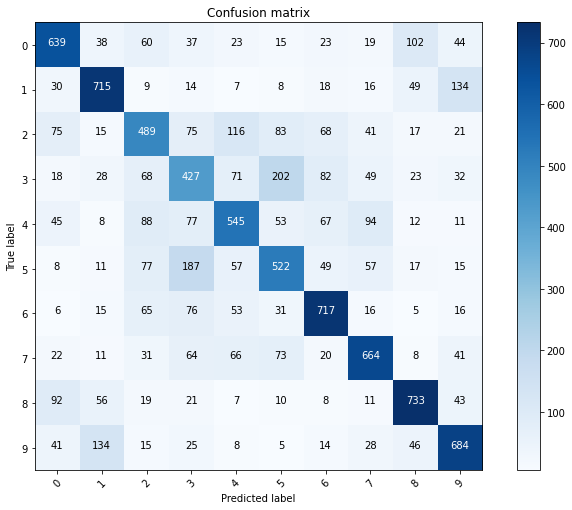

In [28]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# clf.predict(feature_test)
p_test = clf.predict(feature_test)
# clf.predict(lags1).argmax(axis=0)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Normalized confusion matrix
[[0.639 0.038 0.06  0.037 0.023 0.015 0.023 0.019 0.102 0.044]
 [0.03  0.715 0.009 0.014 0.007 0.008 0.018 0.016 0.049 0.134]
 [0.075 0.015 0.489 0.075 0.116 0.083 0.068 0.041 0.017 0.021]
 [0.018 0.028 0.068 0.427 0.071 0.202 0.082 0.049 0.023 0.032]
 [0.045 0.008 0.088 0.077 0.545 0.053 0.067 0.094 0.012 0.011]
 [0.008 0.011 0.077 0.187 0.057 0.522 0.049 0.057 0.017 0.015]
 [0.006 0.015 0.065 0.076 0.053 0.031 0.717 0.016 0.005 0.016]
 [0.022 0.011 0.031 0.064 0.066 0.073 0.02  0.664 0.008 0.041]
 [0.092 0.056 0.019 0.021 0.007 0.01  0.008 0.011 0.733 0.043]
 [0.041 0.134 0.015 0.025 0.008 0.005 0.014 0.028 0.046 0.684]]


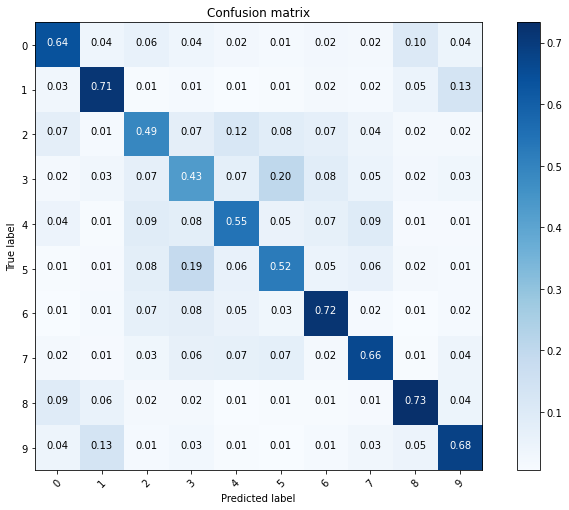

In [29]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# clf.predict(feature_test)
p_test = clf.predict(feature_test)
# clf.predict(lags1).argmax(axis=0)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [0]:
airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9